### Aim of this class
In this class we will employ formants for classifying vowels for a specific speaker. To this end, you will first need to:

1) Record different vowels in four different pitch heights each (e.g. 'a', 'o' and 'ee').

2) pip install conch_sounds

3) The above mentioned library can be found here: https://github.com/mmcauliffe/Conch-sounds

#### Caution: to make the aforementioned library work, you need to make a code change according to this issue:
https://github.com/mmcauliffe/Conch-sounds/issues/12

The following cells include functions and processes for extracting formants among other features from recordings of vowels. These features are stored in structures which are subsequently used for generating graphs and for having a first look at Principal Component Analysis.

### Praat vs Python
Praat offers intuitive interaction with recordings, which is extremely useful for thorough investigation of specific short recorded segments. Python does not include the interaction layer, but it allows the development of specialised algorithms for analysing multiple recordings.

In [1]:
from conch.analysis.formants import FormantTrackFunction
from conch.analysis.pitch import PitchTrackFunction
import librosa
import numpy as np

# define a function for extracting the desired features and for storing them in proper structures for further processing

def get_pitch_and_formants(f):
    func = PitchTrackFunction(time_step=0.01, min_pitch=75, max_pitch=600)
    pitch = func(f)
    func = FormantTrackFunction(time_step=0.01,
                                window_length=0.025, num_formants=5, max_frequency=5500)
    formants = func(f)
    # sync
    kp = np.array( list( pitch.keys() ) )
    kf = np.array( list( formants.keys() ) )
    
    synced = {}
    for t in kp:
        # find nearest value in formants
        idx = (np.abs( kf - t )).argmin()
        formants_freqs_list = []
        formants_ratios_list = []
        formants_amps_list = []
        current_pitch = pitch[ t ]
        if current_pitch[0] != 0:
            for fmnt in formants[ kf[ idx ] ]:
                if current_pitch[0] is not None and fmnt[0] is not None:
                    formants_freqs_list.append( fmnt[0] )
                    formants_amps_list.append( fmnt[1] )
                    formants_ratios_list.append( fmnt[0]/current_pitch[0] )
            synced[ t ] = {
                'pitch': pitch[ t ],
                'time': t,
                'formants_freqs': formants_freqs_list,
                'formants_amps': formants_amps_list,
                'formants_ratios': formants_ratios_list,
            }
    
    return synced, pitch, formants, kp, kf
# end get_pitch_and_formants

In [3]:
# run for audio files
ah_pitch_formants = []
oh_pitch_formants = []
eeh_pitch_formants = []
gt_pitch_formants = []
for i in range(4):
    sa, _, _, _, _ = get_pitch_and_formants( '../audio_files/ah/ah_' + str(i) + '.wav' )
    ah_pitch_formants.append( sa )
    so, _, _, _, _ = get_pitch_and_formants( '../audio_files/oh/oh_' + str(i) + '.wav' )
    oh_pitch_formants.append( so )
    see, _, _, _, _ = get_pitch_and_formants( '../audio_files/eeh/eeh_' + str(i) + '.wav' )
    eeh_pitch_formants.append( see )
    gt, _, _, _, _ = get_pitch_and_formants( '../audio_files/gt/gt_' + str(i) + '.wav' )
    gt_pitch_formants.append( gt )

# sachirp, _, _, tachirp, _ = get_pitch_and_formants( 'audio_files/ah/ah_chirp.wav' )
# sochirp, _, _, tochirp, _ = get_pitch_and_formants( 'audio_files/oh/oh_chirp.wav' )

/Users/max/miniforge3/envs/spyder/lib/python3.9/site-packages/conch/analysis/formants/lpc.py:219: FutureWarning: Pass orig_sr=22050, target_sr=11000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  proc = librosa.resample(proc, sr, new_sr)
/Users/max/miniforge3/envs/spyder/lib/python3.9/site-packages/conch/analysis/formants/lpc.py:219: FutureWarning: Pass orig_sr=22050, target_sr=11000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  proc = librosa.resample(proc, sr, new_sr)


In [4]:
import librosa.display
import matplotlib.pyplot as plt

# define a function for ploting structures

def compount_pitch_formants_plot(file_name, pitch_formants, plt_alias, idx):
    y, sr = librosa.load(file_name, sr=44100)
    n_fft = 8096
    hop_size = 256
    p = librosa.stft(y, n_fft=n_fft, hop_length=hop_size)
    d = librosa.amplitude_to_db( np.abs(p), ref=np.max )
    librosa.display.specshow(d, cmap='gray_r', sr=sr, hop_length=hop_size, x_axis='time', y_axis='linear', ax=plt_alias)
    # and also, if we restrict to speech-relevant frequencies
    lowest_freq = 30
    highest_freq = 5000
    # plt_alias.ylim([lowest_freq, highest_freq])
    plt_alias.set_ylim([lowest_freq, highest_freq])

    # append pitch
    p = []
    t = []
    fmnts = []
    for k in list( pitch_formants.keys() ):
        a = pitch_formants[k]
        p.append( a['pitch'] )
        t.append( a['time'] )
        fmnts.append( a['formants_freqs'] )

    p = np.array( p )
    t = np.array( t )
    plt_alias.plot( t , p , 'r.' )
    for i in range( t.size ):
        for j in range( len(fmnts[i]) ):
            plt_alias.plot( t[i] , fmnts[i][j] , 'b.' )

The following plots are better examined in Praat, which offers valuable interaction possibilities. Ploting in Python offers a first intuitive approach on what differences we should expect from the data.

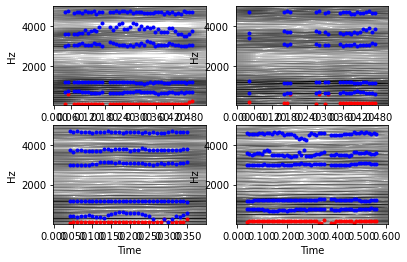

In [6]:
fig,a =  plt.subplots(2,2)

for i in range( 4 ):
    file_name = '../audio_files/ah/ah_' + str(i) + '.wav'
    pitch_formants = ah_pitch_formants[i]
    compount_pitch_formants_plot(file_name, pitch_formants, a[i//2][i%2], i)

fig.savefig('../figs/ahs.png', dpi=500)

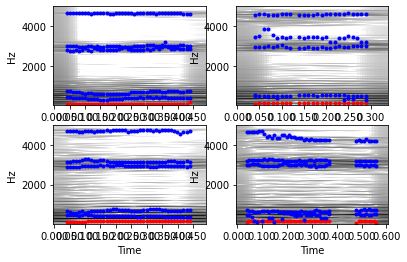

In [7]:
fig,a =  plt.subplots(2,2)

for i in range( 4 ):
    file_name = '../audio_files/oh/oh_' + str(i) + '.wav'
    pitch_formants = oh_pitch_formants[i]
    compount_pitch_formants_plot(file_name, pitch_formants, a[i//2][i%2], i)

fig.savefig('../figs/ohs.png', dpi=500)

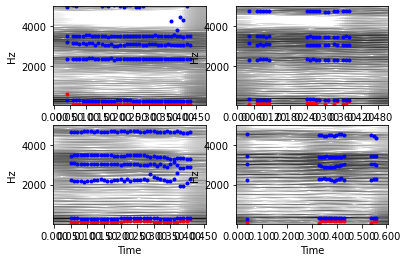

In [8]:
fig,a =  plt.subplots(2,2)

for i in range( 4 ):
    file_name = '../audio_files/eeh/eeh_' + str(i) + '.wav'
    pitch_formants = eeh_pitch_formants[i]
    compount_pitch_formants_plot(file_name, pitch_formants, a[i//2][i%2], i)

fig.savefig('../figs/eehs.png', dpi=500)

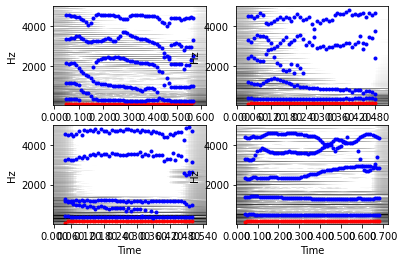

In [9]:
fig,a =  plt.subplots(2,2)

for i in range( 4 ):
    file_name = '../audio_files/gt/gt_' + str(i) + '.wav'
    pitch_formants = gt_pitch_formants[i]
    compount_pitch_formants_plot(file_name, pitch_formants, a[i//2][i%2], i)

fig.savefig('../figs/gt.png', dpi=500)

In [11]:
# function for forming a matrix that incorporates 5-tuples of formants
# for each frame and for every recording of a vowel
def isolate_5_formant_stats(s):
    fmnts = np.zeros( ( len(s) , 5 ) )
    nnz = 0
    for i , k in enumerate( list( s.keys() ) ):
        a = s[k]
        tmp_arr = np.array(a['formants_freqs'])
        if tmp_arr.size == 5 and 0 not in tmp_arr:
            fmnts[i, :] = tmp_arr
            nnz += 1
    ret_fmnts = np.zeros( ( nnz , 5 ) )
    nnz = 0
    for i in range( fmnts.shape[0] ):
        if np.sum( fmnts[i,:] ) > 0:
            ret_fmnts[nnz, :] = fmnts[i,:]
            nnz += 1
    return ret_fmnts

Using the function defined above, all the identified formants are isolated (stacked) for every recording of each vowel. For example, the first cell includes the formants identified for all recordings of 'a'.

Each vowel is then ploted with boxplots. Each box corresponds to the distribution of the respective formant.

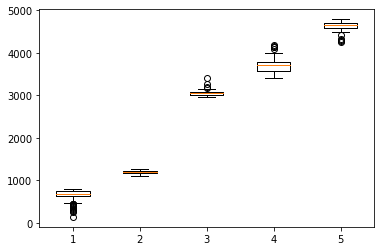

In [12]:
ah_stacked = isolate_5_formant_stats( ah_pitch_formants[0] )
for i in range( 1, 4, 1 ):
    ah_stacked = np.vstack( ( ah_stacked , isolate_5_formant_stats( ah_pitch_formants[i] ) ) )

_ = plt.boxplot( ah_stacked )
plt.savefig('../figs/ah_boxplot.png', dpi=500)

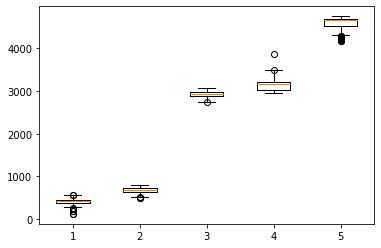

In [13]:
oh_stacked = isolate_5_formant_stats( oh_pitch_formants[0] )
for i in range( 1, 4, 1 ):
    oh_stacked = np.vstack( ( oh_stacked , isolate_5_formant_stats( oh_pitch_formants[i] ) ) )

_ = plt.boxplot( oh_stacked )
plt.savefig('../figs/oh_boxplot.png', dpi=500)

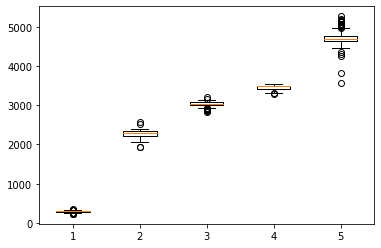

In [14]:
eeh_stacked = isolate_5_formant_stats( eeh_pitch_formants[0] )
for i in range( 1, 4, 1 ):
    eeh_stacked = np.vstack( ( eeh_stacked , isolate_5_formant_stats( eeh_pitch_formants[i] ) ) )

_ = plt.boxplot( eeh_stacked )
plt.savefig('../figs/eeh_boxplot.png', dpi=500)

A boxplot of all formants of all vowels reveals that there are significant differences in the formants layout. For example, F1 and F2 are distinctive for all vowel recordings.

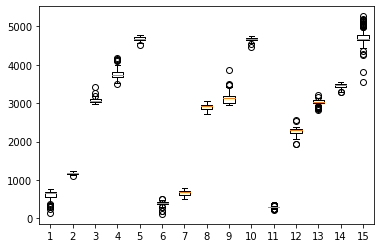

In [15]:
# combined plot
idx = np.min( np.array( [ah_stacked.shape[0] , oh_stacked.shape[0] , eeh_stacked.shape[0] ] ) )
comp = np.hstack( ( ah_stacked[:idx,:] , oh_stacked[:idx,:] , eeh_stacked[:idx,:] ) )

_ = plt.boxplot( comp )
plt.savefig('../figs/comp_boxplot.png', dpi=500)

Ploting the first two formants (F1 on x and F2 on y) shows that F2, in its own right, is enough for linearly separating the vowel recordings (i.e. by drawing horizontal lines).

/var/folders/k_/fvgjkvys5yq973r5xjs_hknc0000gp/T/ipykernel_21117/1501288537.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


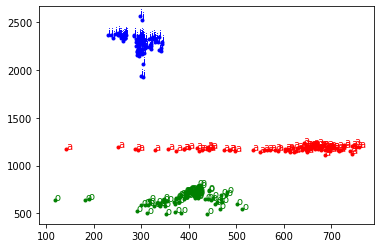

In [16]:
letters = [ 'a' , 'o' , 'i' ]
colors = [ 'r' , 'g' , 'b' ]
compv = np.vstack( ( ah_stacked[:idx,:] , oh_stacked[:idx,:] , eeh_stacked[:idx,:] ) )
idxs = np.hstack( ( 0*np.ones( idx ) , 1*np.ones( idx ) , 2*np.ones( idx ) ) ).astype(int)

fig,a =  plt.subplots()

for i in range( compv.shape[0] ):
    a.plot( compv[i,0] , compv[i,1] , '.', color=colors[idxs[i]] )
    a.annotate( letters[ idxs[i] ] , (compv[i,0] , compv[i,1]) , color = colors[ idxs[i] ] )

fig.show()
fig.savefig( '../figs/comp_2d.png' , dpi=500 )

Can we get even better discrimination? Yes, by applying Principal Component Analysis (PCA). PCA brings into play all the formants, which reveal additional aspects and subgroups within each vowel space.

/var/folders/k_/fvgjkvys5yq973r5xjs_hknc0000gp/T/ipykernel_21117/3412392028.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


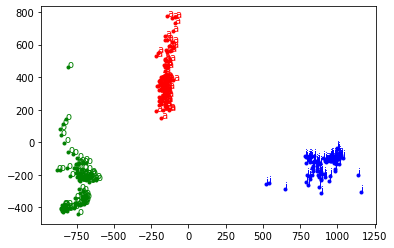

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(compv)
transformed = pca.transform(compv)

fig,a =  plt.subplots()

for i in range( compv.shape[0] ):
    a.plot( transformed[i,0] , transformed[i,1] , '.', color=colors[idxs[i]] )
    a.annotate( letters[ idxs[i] ] , (transformed[i,0] , transformed[i,1]) , color = colors[ idxs[i] ] )

fig.show()
fig.savefig( '../figs/comp_PCA.png' , dpi=500 )